In [32]:
from QuantLib import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
depo_maturities = [Period(6, Months), Period(12, Months)]
depo_rates = [5.25, 5.5]

#Bond Rates
bond_maturities = [Period(6*i, Months) for i in range(3, 21)]
bond_rates = [5.75, 6.0, 6.25, 6.5, 6.75, 6.80, 7.00, 7.1, 7.15,
             7.2, 7.3, 7.35, 7.4, 7.5, 7.6, 7.6, 7.7, 7.8]
maturities = depo_maturities + bond_maturities
rates = depo_rates + bond_rates
pd.DataFrame(list(zip(maturities, rates)),
            columns=['Maturities', 'Curve'],
            index=['']*len(rates))

,Maturities,Curve
,6M,5.25
,1Y,5.50
,1Y6M,5.75
,2Y,6.00
,2Y6M,6.25
,3Y,6.50
,3Y6M,6.75
,4Y,6.80
,4Y6M,7.00
,5Y,7.10


In [6]:
calc_date = Date(15, 1, 2015)
Settings.instance().evaluationDate = calc_date

calendar = UnitedStates()
business_convention = Unadjusted
day_count = Thirty360()
end_of_month = True
settlement_days = 0
face_amount = 100
coupon_frequency = Period(Semiannual)

In [8]:
depo_helpers = [DepositRateHelper(QuoteHandle(SimpleQuote(r/100.0)),
                                 m,
                                 settlement_days,
                                 calendar,
                                 business_convention,
                                 end_of_month,
                                 day_count)
                for r, m in zip(depo_rates, depo_maturities)]

In [12]:
bond_helpers =[]
for r, m in zip(bond_rates, bond_maturities):
    termination_date = calc_date + m
    schedule  = Schedule(calc_date,
                        termination_date,
                        coupon_frequency,
                        calendar,
                        business_convention,
                        business_convention,
                        DateGeneration.Backward,
                        end_of_month)
    bond_helper = FixedRateBondHelper(QuoteHandle(SimpleQuote(face_amount)),
                                     settlement_days,
                                     face_amount,
                                     schedule,
                                     [r/100],
                                     day_count,
                                     business_convention)
    bond_helpers.append(bond_helper)

In [14]:
rate_helpers = depo_helpers + bond_helpers

In [21]:
def get_spot_rates(yieldcurve, day_count, calendar=UnitedStates(), months=121):
    spots = []
    tenors = []
    ref_date = yieldcurve.referenceDate()
    calc_date = ref_date
    for month in range(0, months):
        yrs = month/12
        d = calendar.advance(ref_date, Period(month, Months))
        compounding = Compounded
        freq = Semiannual
        zero_rate = yieldcurve.zeroRate(yrs, compounding, freq)
        tenors.append(yrs)
        eq_rate = zero_rate.equivalentRate(day_count, compounding, freq, calc_date, d).rate()
        spots.append(100*eq_rate)
    return pd.DataFrame(list(zip(tenors, spots)), 
                           columns=["Maturities", "Curve"],
                           index=['']*len(tenors))

In [26]:
yc_logCubicDiscount = PiecewiseLogCubicDiscount(calc_date, rate_helpers, day_count)
sr_lcd = get_spot_rates(yc_logCubicDiscount, day_count)
sr_lcd.tail()

,Maturities,Curve
,9.666667,7.981384
,9.750000,8.005292
,9.833333,8.028145
,9.916667,8.050187
,10.000000,8.071649


In [27]:
yc_linearZero = PiecewiseLinearZero(calc_date, rate_helpers, day_count)
yc_cubicZero = PiecewiseCubicZero(calc_date, rate_helpers, day_count)

sr_lz = get_spot_rates(yc_linearZero, day_count)
sr_cz = get_spot_rates(yc_cubicZero, day_count)
sr_lz.tail()

,Maturities,Curve
,9.666667,7.976804
,9.750000,8.000511
,9.833333,8.024221
,9.916667,8.047934
,10.000000,8.071649


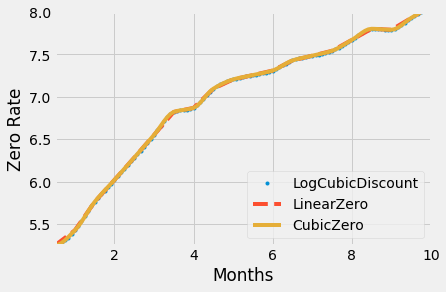

In [33]:

#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b \'%y'))
#plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
plt.plot(sr_lcd['Maturities'], sr_lcd['Curve'] , '.', label='LogCubicDiscount')
plt.plot(sr_lz['Maturities'], sr_lz['Curve'] , '--', label='LinearZero')
plt.plot(sr_cz['Maturities'], sr_cz['Curve'] , label='CubicZero')
plt.xlabel('Months')
plt.ylabel('Zero Rate')
plt.axis([0.5, 10, 5.25, 8])
plt.legend(['LogCubicDiscount', 'LinearZero', 'CubicZero'])
